### Feedforward 
```
MNIST
DataLoader, Transformation
Multilayer Neural Net, activation function
Loss and Optimizer
Training Loop (batch training)
Model evaluation
GPU support


In [2]:
import torch
import torch.nn as nn 
import torchvision
# from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# hyper parameters

# input_size = 784 # image size = 28*28, reshapes to 1D
hidden_size = 128
num_classes = 10 # 0,1,2 .... 9
num_epochs = 2
batch_size = 100
learning_rate = 0.001

input_size = 28
sequence_length = 28
num_layers = 2


MNIST Dataset

In [5]:
train_dataset = torchvision.datasets.MNIST(root='data', train=True,
                            transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='data', train=False,
                                          transform=transforms.ToTensor())

In [6]:
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


Data loader

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100,
                                          shuffle=False)

In [8]:
example = iter(train_loader)
samples, labels = example.__next__()
print(samples.shape, labels.shape) # 100 smaples(batch_size), 1 channel, 28*28 image size

torch.Size([100, 1, 28, 28]) torch.Size([100])


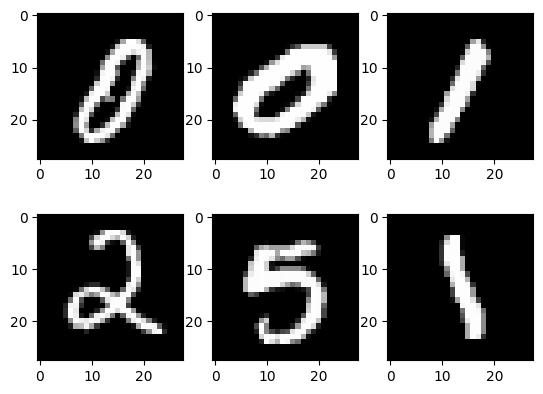

In [9]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
plt.show()

Model

* we can further replace this with GRU, LSTM

In [16]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size,num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # x -> (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        # out = batch_size, sequence_length, hidden_size
        # out (N, 28, 28)
        out = out[:, -1, :]
        # out (N, 128)
        out = self.fc(out)
        return out

        
        
    
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# LSTM implementation

In [ ]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size,num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # x -> (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.rnn(x, (h0, c0))
        # out = batch_size, sequence_length, hidden_size
        # out (N, 28, 28)
        out = out[:, -1, :]
        # out (N, 128)
        out = self.fc(out)
        return out

        
        
    
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

Loss and Optimizer

In [17]:
criterion = nn.CrossEntropyLoss() #multiclass classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training loop

In [18]:
n_total_steps = len(train_loader) # total batches - 600

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): #i -> iterations
        # 100, 1, 28, 28
        #reshaping 2D -> 1D
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        #forward pass and loss
        outputs = model(images) # forward(x)
        loss = criterion(outputs, labels)

        #backward
        loss.backward()

        #update
        optimizer.step()

        #zero_grad
        optimizer.zero_grad()
        
        if (i+1) % 100 == 0:
            print(f'epoch: {epoch+1}/{num_epochs}, iter:{i+1}/{n_total_steps}, loss: {loss.item():.4f}')

epoch: 1/2, iter:100/600, loss: 0.9963
epoch: 1/2, iter:200/600, loss: 0.6490
epoch: 1/2, iter:300/600, loss: 0.5197
epoch: 1/2, iter:400/600, loss: 0.3891
epoch: 1/2, iter:500/600, loss: 0.2913
epoch: 1/2, iter:600/600, loss: 0.4567
epoch: 2/2, iter:100/600, loss: 0.3923
epoch: 2/2, iter:200/600, loss: 0.1307
epoch: 2/2, iter:300/600, loss: 0.1889
epoch: 2/2, iter:400/600, loss: 0.2877
epoch: 2/2, iter:500/600, loss: 0.2600
epoch: 2/2, iter:600/600, loss: 0.1827


Testing / Evaulation

In [19]:
with torch.no_grad():
    nof_correct = 0
    nof_samples = 0
    for images, labels in test_loader:
        
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        outputs = model(images)

        #returns value, index
        _, predictions = torch.max(outputs, 1) #values, dim

        nof_samples += labels.shape[0]  #100
        nof_correct += (predictions == labels).sum().item()

    acc = nof_correct / nof_samples * 100
    print(f'accuracy = {acc}')

accuracy = 92.54


Testing single image

In [20]:
test1 = iter(test_loader)
images, samples = test1.__next__()

In [21]:
images.shape

torch.Size([100, 1, 28, 28])

Testing

tensor([9])


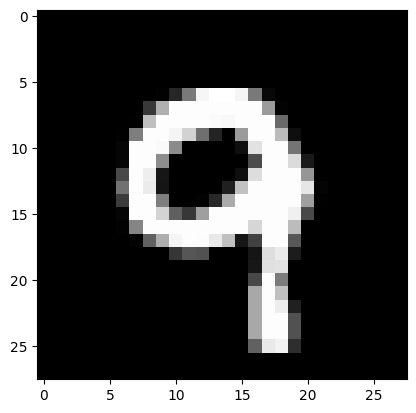

In [23]:
img = images[99][0]

plt.imshow(img, cmap='gray')
plt.imshow

test = img.reshape(-1, sequence_length, input_size)
output = model(test)
#returns value, index
_, predictions = torch.max(output, 1) #values, dim

print(predictions)
